<a href="https://colab.research.google.com/github/AIWintermuteAI/Bertelsmann-Tech-Scholarship-Challenge-Course---AI-Track-Nanodegree-Program/blob/master/CatDogMNIST_(Solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CatDogMNIST

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

<img src='https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/assets/dog_cat.png?raw=1'>

It's a fun exercise to use the knowledge about building FC neural netowrks with pytorch and transform cats-vs-dogs Kaggle dataset into a MNIST like dataset that this model can (sort of) learn.

We'll start by downloading and unzipping the dataset.

In [1]:
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -q Cat_Dog_data.zip 

--2020-02-05 15:04:40--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.207.85
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.207.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  35.6MB/s    in 16s     

2020-02-05 15:04:57 (33.9 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



Next we'll do the necesary imports. Nothing special, mostly the stuff we had in the original notebook by Udacity, plus Python random module.

In [0]:
import matplotlib.pyplot as plt
import random
import torch
from torchvision import datasets, transforms

Create the training and testing loaders --- use the same transform for both, since using image augumentations is too hardcore for our simple fully-connected model.

In [0]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize(28),
                                transforms.CenterCrop(28),
                                transforms.ToTensor()])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32,shuffle=True)

And check the results in the first batch. Well, it's not too bad. I can distinguish between cats and dogs in most images.

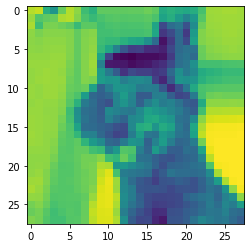

tensor(1)


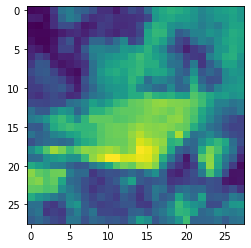

tensor(0)


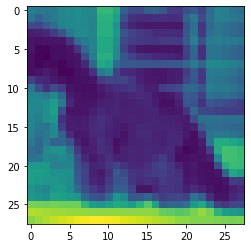

tensor(0)


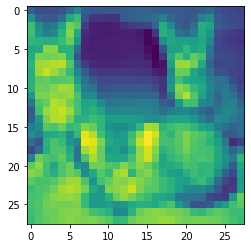

tensor(0)


In [4]:
# change this to the trainloader or testloader 
data_iter = iter(trainloader)
images, labels = next(data_iter)
for ii in range(4):
  num = random.randint(0, len(images)-1)
  plt.imshow(images[num].view(28, 28))
  plt.show()
  print(labels[num])


Great! Let's define our model. We'll use the model similiar to the one we used before for MNIST and FashionMNIST. The only significant change is adding a multiplier to optionally make the network wider.

In [0]:
from torch import nn, optim
import torch.nn.functional as F

multiplier = 1
dropout = 0.2

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, int(256*multiplier))
        self.fc2 = nn.Linear(int(256*multiplier), int(128*multiplier))
        self.fc3 = nn.Linear(int(128*multiplier), int(64*multiplier))
        self.fc4 = nn.Linear(int(64*multiplier), 2)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 30
steps = 0

And finally let our little brave model start the training. I had the following results for 0.5, 1 and 2 multiplier after 30 epochs.

In [0]:
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        model.eval()
        for images, labels in testloader:
          ps = model(images)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          test_loss += criterion(ps, labels)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        print("Epoch: {}/{}.. ".format(e+1, epochs),
        "Training Loss: {:.3f}.. ".format(train_losses[-1]),
        "Test Loss: {:.3f}.. ".format(test_losses[-1]),
        "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.688..  Test Loss: 0.675..  Test Accuracy: 0.581
Epoch: 2/30..  Training Loss: 0.673..  Test Loss: 0.663..  Test Accuracy: 0.610
Epoch: 3/30..  Training Loss: 0.665..  Test Loss: 0.659..  Test Accuracy: 0.606
Epoch: 4/30..  Training Loss: 0.660..  Test Loss: 0.658..  Test Accuracy: 0.618
Epoch: 5/30..  Training Loss: 0.658..  Test Loss: 0.652..  Test Accuracy: 0.620
Epoch: 6/30..  Training Loss: 0.654..  Test Loss: 0.651..  Test Accuracy: 0.625
Epoch: 7/30..  Training Loss: 0.652..  Test Loss: 0.651..  Test Accuracy: 0.621
Epoch: 8/30..  Training Loss: 0.649..  Test Loss: 0.647..  Test Accuracy: 0.624
Epoch: 9/30..  Training Loss: 0.647..  Test Loss: 0.652..  Test Accuracy: 0.621
Epoch: 10/30..  Training Loss: 0.646..  Test Loss: 0.645..  Test Accuracy: 0.625
Epoch: 11/30..  Training Loss: 0.644..  Test Loss: 0.643..  Test Accuracy: 0.636
Epoch: 12/30..  Training Loss: 0.641..  Test Loss: 0.647..  Test Accuracy: 0.625
Epoch: 13/30..  Training Loss: 0.640.